# Train Mask R-CNN with Chess Dataset

Based on https://github.com/RussTedrake/manipulation/blob/master/segmentation_train.ipynb

The .py version works better but this is nice if u want to know how its done

In [5]:
# !pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision && git checkout v0.3.0
# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

# Imports
import os.path as osp

import fnmatch
import json
import matplotlib.pyplot as plt
# import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

from engine import train_one_epoch, evaluate
import vision.references.detection.utils as utils
import vision.references.detection.transforms as T
# import transforms as T

from chess_bot.utils.path_util import get_chessbot_src


In [6]:
dataset_path = osp.join(get_chessbot_src(), 'resources/training_data')

# ycb = [
#     "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
#     "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
# ]

pieces = [
    'BB', # : 'Bishop_B.urdf',
    'BW', # : 'Bishop_W.urdf',

    'KB', # : 'King_B.urdf',
    'KW', # : 'King_W.urdf',

    'NB', # : 'Knight_B.urdf',
    'NW', # : 'Knight_W.urdf',

    'PB', # : 'Pawn_B.urdf',
    'PW', # : 'Pawn_W.urdf',

    'QB', # : 'Queen_B.urdf',
    'QW', # : 'Queen_W.urdf',

    'RB', # : 'Rook_B.urdf',
    'RW', # : 'Rook_W.urdf'
]

def get_piece_from_label(label):
    return pieces[label - 1]


In [7]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.num_images = len(fnmatch.filter(os.listdir(root),'*.png'))

        with open(osp.join(root, 'id_to_name.json'), "r") as f:
            instance_id_to_class_name = json.load(f)

        self.instance_id_to_class_name = instance_id_to_class_name
        self.obj_ids = np.asarray(list(instance_id_to_class_name.keys())) 
    
    def __getitem__(self, idx):
        filename_base = os.path.join(self.root, f"board_{idx:05}")

        img = Image.open(filename_base + '.png').convert('RGB')
        mask = np.squeeze(np.load(filename_base + '_mask.npy'))

        count = (mask == np.int16(self.obj_ids)[:, None, None]).sum(axis=2).sum(axis=1)

        # print(count)
        
        # discard objects instances with less than 10 pixels
        local_obj_ids = self.obj_ids[count >= 10] 

        labels = []
        for id in local_obj_ids:
            piece = self.instance_id_to_class_name[id][-2:]  # piece type is last two values
            labels.append(pieces.index(piece) + 1)
        
        local_obj_ids = np.int16(np.asarray(local_obj_ids))

        masks = mask == local_obj_ids[:, None, None]  # bool mask
        print('masks: ', masks.shape)

        # get bounding box coordinates for each mask
        num_objs = len(local_obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.num_images

masks:  (21, 1080, 1920)


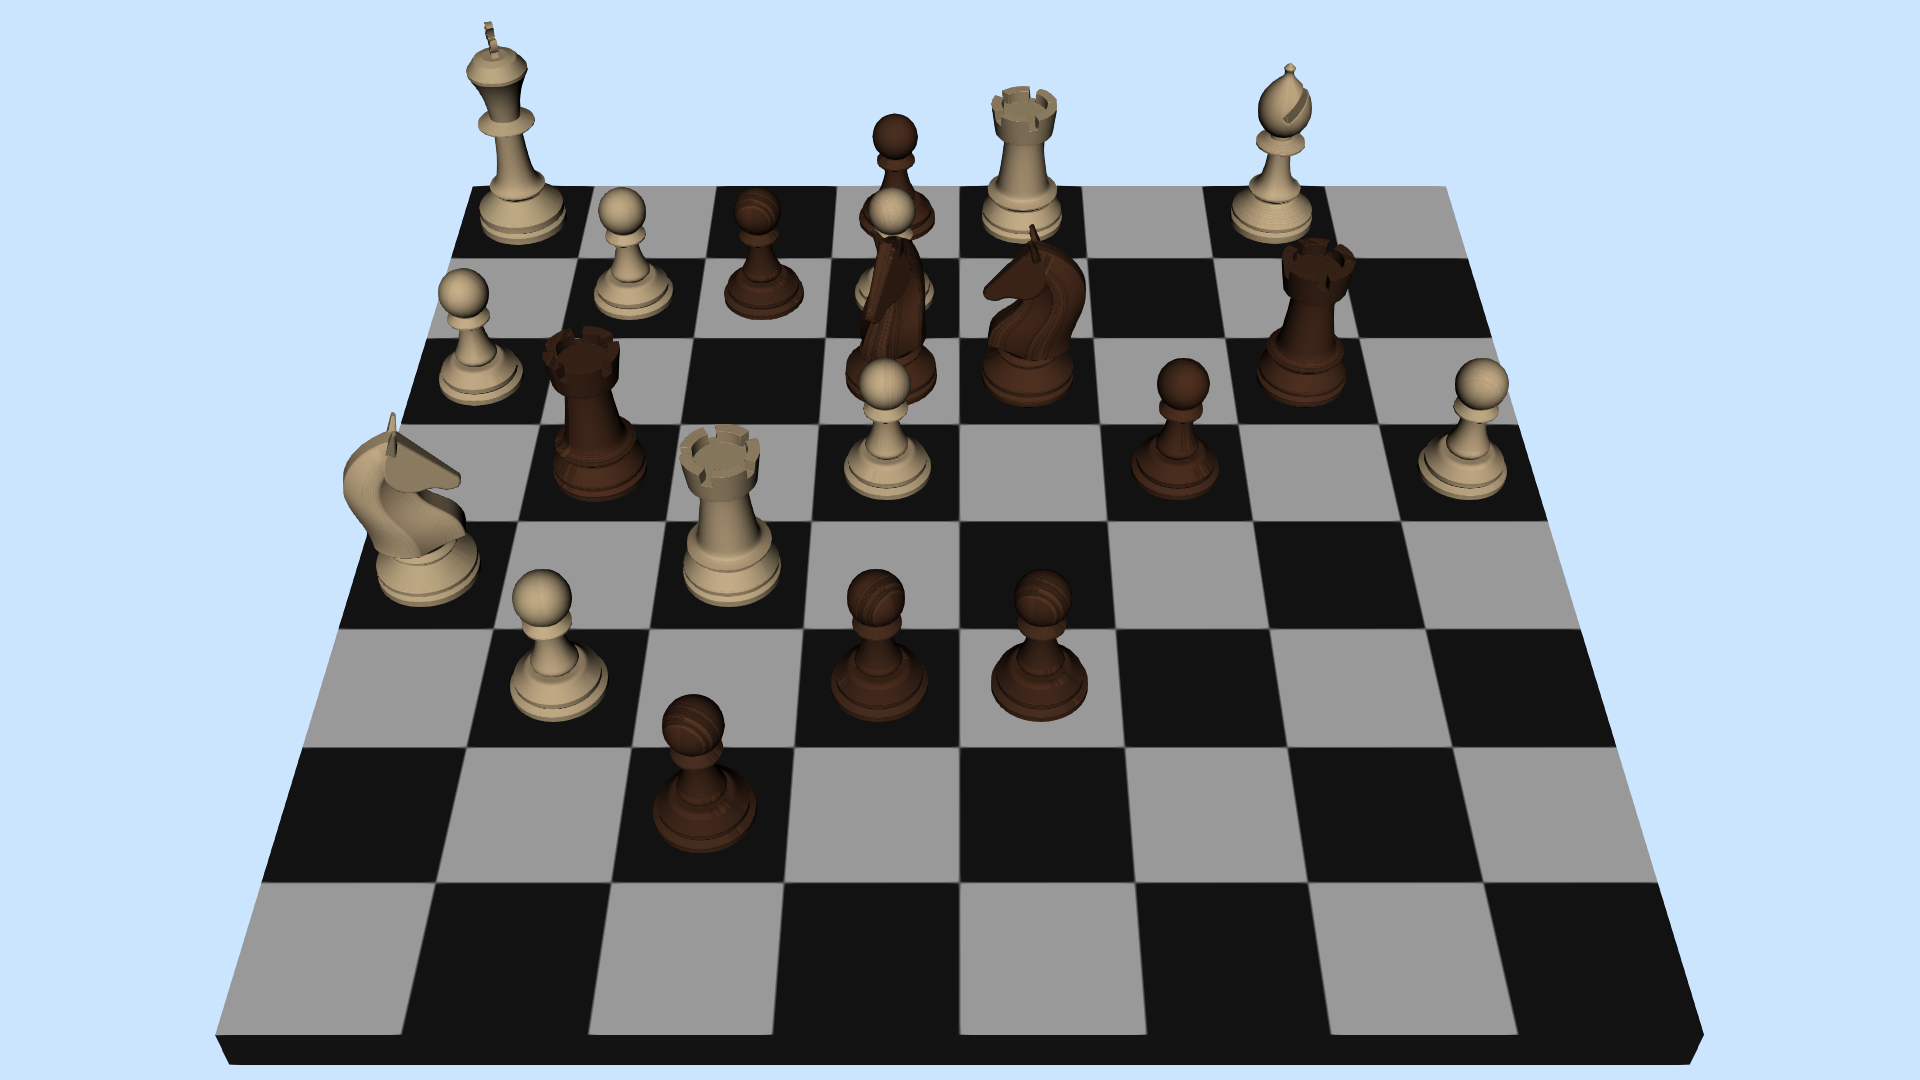

In [8]:
dataset = ChessDataset(dataset_path)
# print(dataset[0])
dataset[1][0]
# mask0 = dataset[0][1]['masks'][0]
# mask1 = dataset[0][1]['masks'][1]
# plt.imshow(mask0)

In [9]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
# use our dataset and defined transformations
dataset = ChessDataset(dataset_path, get_transform(train=True))
dataset_test = ChessDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Multiprocessing doesn't work in ipynb on mac... might work with cuda tho
# define training and validation data loaders
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(pieces)+1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

## Visualize Network Results

The code below here is kinda shoddy but like oh well

In [17]:
weight_path = osp.join(get_chessbot_src(), 'resources/weights')
model.load_state_dict(torch.load(osp.join(weight_path, 'chess_maskrcnn_model_ror.pt'), map_location=device))
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

masks:  (7, 1080, 1920)


In [18]:
prediction

[{'boxes': tensor([[ 814.6592,  834.9174,  923.8853, 1001.2918],
          [1259.5190,  267.3275, 1341.6942,  405.5306],
          [ 990.5281,  657.2914, 1099.4014,  855.4526],
          [ 731.0480,   85.9223,  811.8727,  242.5966],
          [ 366.8018,  409.2406,  479.8894,  606.0128],
          [1354.2186,   72.7027, 1461.6760,  243.9964],
          [ 800.8373,  651.4622,  931.6136,  852.9343]]),
  'labels': tensor([ 8,  7, 12, 11,  1,  6,  5]),
  'scores': tensor([0.9999, 0.9998, 0.9990, 0.9989, 0.9989, 0.9984, 0.9981]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0

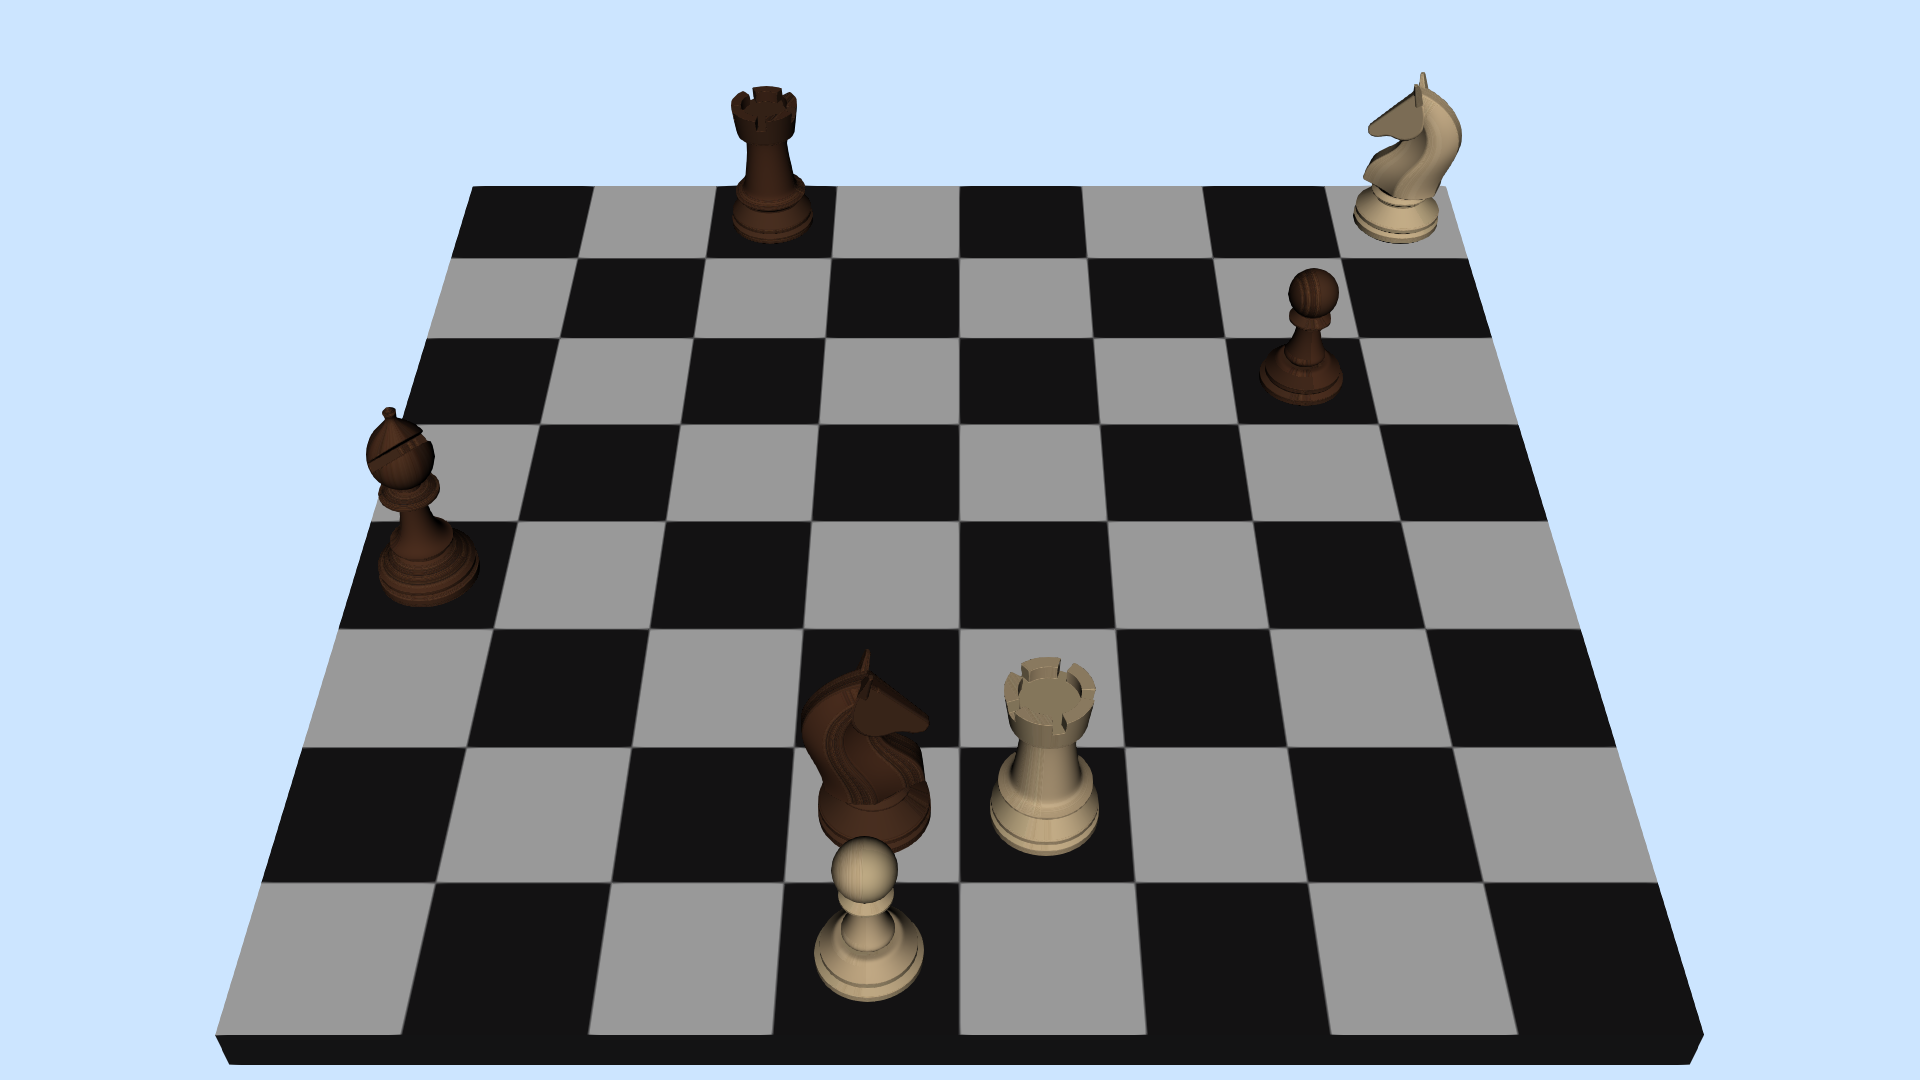

In [19]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

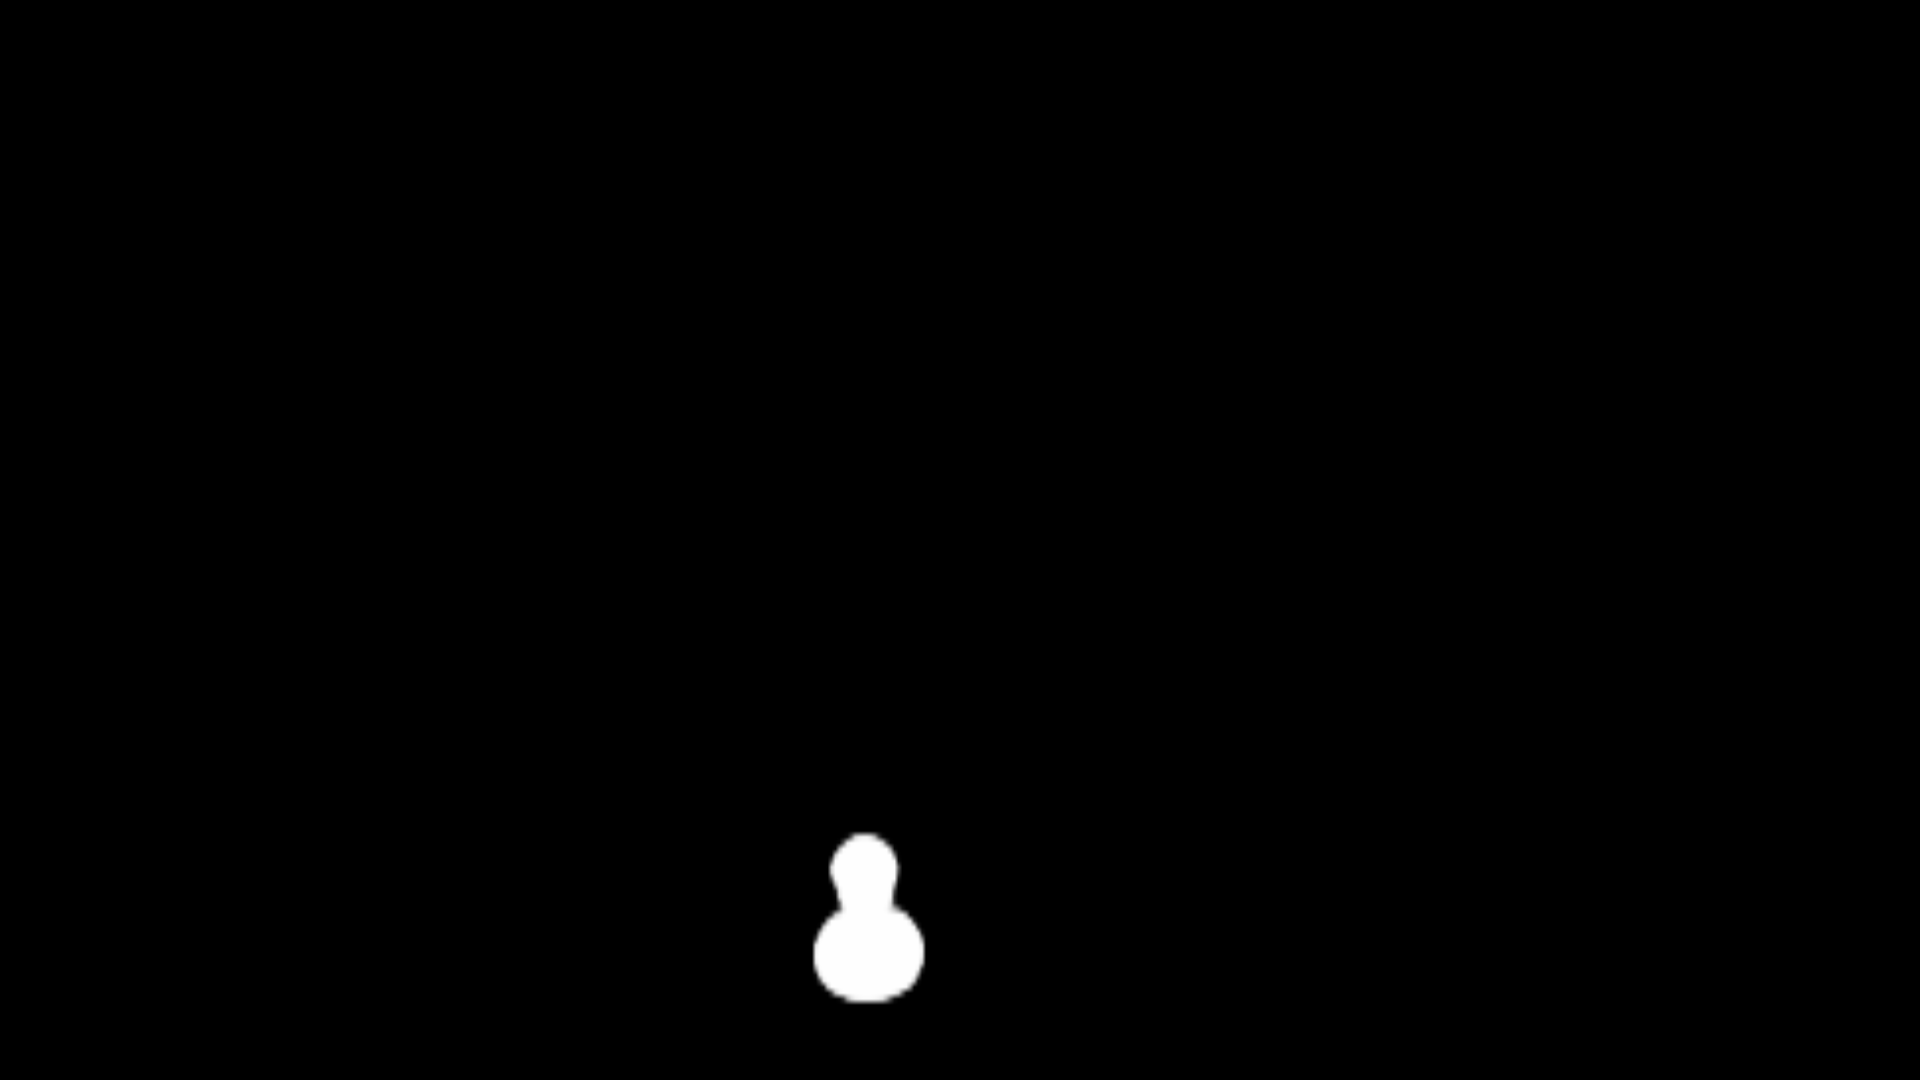

In [20]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [21]:
labels = list(prediction[0]['labels'].cpu().detach().numpy())
scores = list(prediction[0]['scores'].cpu().detach().numpy()) 

for i, label in enumerate(labels):
    print(i, label, get_piece_from_label(label), scores[i])

0 8 PW 0.99985397
1 7 PB 0.9997907
2 12 RW 0.999044
3 11 RB 0.9989201
4 1 BB 0.9988997
5 6 NW 0.99839324
6 5 NB 0.99811375


In [24]:
labels_true = list(dataset_test[4][1]['labels'].cpu().detach().numpy())

for i, label in enumerate(labels_true):
    print(i, label, pieces[label - 1], scores[i])

# mask0 = dataset[0][1]['masks'][0]

masks:  (7, 1080, 1920)
0 6 NW 0.99985397
1 12 RW 0.9997907
2 8 PW 0.999044
3 11 RB 0.9989201
4 1 BB 0.9988997
5 5 NB 0.99839324
6 7 PB 0.99811375
